# Utilisation de PyTorch à plus haut niveau

Dans ce TP, on se familiarise avec les fonctionnalités de la librairie PyTorch pour la construction et l'apprentissage d'une architecture de réseau de neurones.

On utilise à nouveau les données MNIST et on considère la même architecture "dense" (pas de Convolution ici) que dans le TP1.  Les images sont donc considérées comme des vecteurs de tailles 28*28.

Attention, on rappelle que les architectures PyTorch prennent les données en lignes.

In [93]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Lambda
from torchmetrics import Accuracy

## 1 - Chargement et lecture des données

PyTorch fournit deux classes `torch.utils.data.DataLoader` et `torch.utils.data.Dataset` pour utiliser des jeux de données pré-chargés ou des données externes.

 `Dataset` stocke les échantillons et les labels correspondants, tandis que  `DataLoader` fournit un itérateur pour un accès facile aux échantillons.

En utilisant la classe `DataLoader`, on peut de manière générique appliquer des transformations à la volée pendant l'itération sur le jeu de données (arguments `transform` et `target_transform`), et faire en sorte que l'itération sur le tenseur fourni se fasse dans un ordre aléatoire (argument `shuffle`).

**Vous pourrez vous aider de ce [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#datasets-dataloaders) pour répondre aux questions de cette partie.**

> Créer une composition des deux transformations à appliquer sur les images:
> - La transformée `ToTensor` fait automatiquement la normalisation des pixels.
> - La transformée `Lambda` permet d'appliquer une fonction quelconque, ici pour changer la forme du tenseur (d'une image en un vecteur).
> - La transformée `Compose` permet la composition de transformations.

In [21]:
transform_composition = Compose([ToTensor(), Lambda(lambda t : t.view(1, -1))])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_composition
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_composition
)

> Créer des `DataLoader` pour les jeux de données d'entraînement et de test.

In [100]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

> Vérifier que vous pouvez extraire des échantillon batch de données d'apprentissage, en itérant sur le DataLoader construit.

Feature batch shape: torch.Size([64, 1, 784])
Labels batch shape: torch.Size([64])


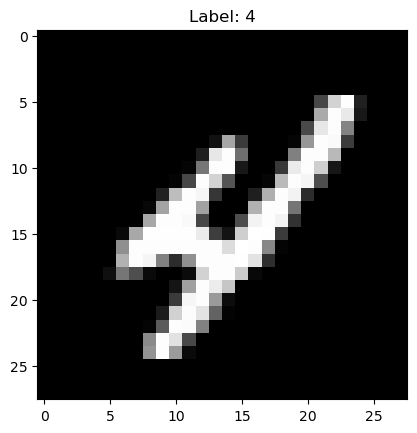

In [23]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].view(28, 28)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.title(f'Label: {label}')
plt.show()

## 2 - Différenciation automatique avec Autograd

Pour calculer des gradients et mettre en oeuvre une descente de gradient, PyTorch dispose du moteur de différenciation automatique `torch.autograd`, qui permet le calcul automatique du gradient pour n'importe quel graphe computationnel.

**Consulter ce [tutorial](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) pour répondre aux questions de cette partie.**

>  On considère la fonction
$$ (w,b) \in \mathbb{R}^5  \times \mathbb R \mapsto   \sum_{j=0}^4  j  \cdot\left(\sin (w_j) +b \right)^2  .$$
> En utilisant autograd, calculer le gradient de cette fontion au point w=0, b = 1.

In [28]:
w = torch.zeros(5, requires_grad=True)
b = torch.ones(1, requires_grad=True)

func = 0
for j in range(5):
    func += j * torch.pow(torch.sin(w[j]) + b, 2)

func.backward()
print(w.grad)
print(b.grad)

tensor([0., 2., 4., 6., 8.])
tensor([20.])


> Reprendre l'implémentation du réseau de neurone construit "à la main dans le TP1", en ne gardant que la méthodes `forward` qui ne renverra que l'activation de la dernière couche. On appellera `Net_sans_gradients` la classe ainsi créée.


In [44]:
class Net_sans_gradients:
    def __init__(self, layers_size = [784, 30, 20, 10]):
        self.layers_size = layers_size
        self.n_layers = len(layers_size) - 1
        self.b = [None]
        for layer_size in layers_size[1:]:
            self.b.append(torch.zeros(1, layer_size, requires_grad=True))

        self.w = [None]
        for previous_layer, actual_layer in zip(layers_size, layers_size[1:]):
            self.w.append(torch.normal(0, 1, size=(previous_layer, actual_layer), requires_grad=True))

    def forward(self, a0):
            a0 = a0.view(1, -1)

            assert a0.size() == (1, self.layers_size[0]), f'Error: wrong input size ({a0.size()=})'

            a = [a0]
            z = [None]
            for l in range(1, self.n_layers + 1):
                z.append(torch.mm(a[l-1], self.w[l] + self.b[l]))
                a.append(logistic(z[l]))

                assert z[l].size() == (1, self.layers_size[l])
                assert a[l].size() == (1, self.layers_size[l])

            return a[self.n_layers]

def logistic(x):
    return 1/(1 + torch.exp(-x))

> Vérifier ensuite que l'on peut obtenir à l'aide d'autograd le gradient de la perte [cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)  appliquée en sortie de ce réseau, par rapport aux paramètres du réseau,  sans avoir bien sûr à implémenter les expressions des gradients dans l'architecture.

In [54]:
net = Net_sans_gradients()
out = net.forward(train_features[0])

loss = torch.nn.CrossEntropyLoss()
l = loss(out.squeeze(), train_labels[0])

l.backward()

net.w[2].grad

tensor([[-4.5379e-07, -3.6419e-05, -1.3220e-05, -1.2052e-07,  1.1672e-07,
         -1.3889e-05,  3.8230e-10,  5.8478e-06,  2.0804e-06,  2.5120e-05,
          1.4126e-05,  9.1725e-09, -2.5452e-05, -1.5798e-06,  9.9393e-06,
         -2.3217e-06,  9.6230e-08,  1.9437e-05, -2.6511e-07, -3.5338e-05],
        [-8.0584e-06, -6.4673e-04, -2.3476e-04, -2.1402e-06,  2.0728e-06,
         -2.4664e-04,  6.7890e-09,  1.0385e-04,  3.6945e-05,  4.4609e-04,
          2.5086e-04,  1.6289e-07, -4.5197e-04, -2.8054e-05,  1.7650e-04,
         -4.1229e-05,  1.7089e-06,  3.4517e-04, -4.7079e-06, -6.2754e-04],
        [-7.6111e-04, -6.1082e-02, -2.2173e-02, -2.0214e-04,  1.9577e-04,
         -2.3294e-02,  6.4121e-07,  9.8082e-03,  3.4894e-03,  4.2132e-02,
          2.3693e-02,  1.5384e-05, -4.2688e-02, -2.6497e-03,  1.6670e-02,
         -3.8940e-03,  1.6140e-04,  3.2601e-02, -4.4465e-04, -5.9270e-02],
        [-3.4889e-09, -2.8000e-07, -1.0164e-07, -9.2661e-10,  8.9742e-10,
         -1.0678e-07,  2.9393e-12, 

## 3 - Construction du réseau par la fonction Sequential


La fonction [`torch.nn.Sequential`](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#nn-sequential) permet de construire facilement un réseau par couches successives.


> Reconstruire le réseau du TP1 par un appel à `torch.nn.Sequential`. Vous appelerez `my_net2` le réseau ainsi créé.
> On pourra afficher les paramètres du réseau avec la fonction `named_parameters`, afin de visualiser ce qui a été créé.

In [63]:
my_net2 = torch.nn.Sequential(
    nn.Linear(784, 30),
    nn.Sigmoid(),
    nn.Linear(30,20),
    nn.Sigmoid(),
    nn.Linear(20,10),
    nn.Sigmoid()
)

for param in my_net2.named_parameters():
    print(param[0])

0.weight
0.bias
2.weight
2.bias
4.weight
4.bias


On peut obtenir la réponse du réseau `my_net2` sur le tenseur a par `my_net2(a)`
> Le réseau n'est pas encore entrainé. Vérifier que les valeurs de cross-entropy et la précision sont très mauvaises :
- sur un batch de l'échantillon d'apprentissage,
- sur l'échantillon d'apprentissage complet,
- sur l'échantillon de test complet.   
>
> On pourra par exemple utiliser la fonction [`accuracy`](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html#id3) de `torchmetrics`.

In [91]:
def verify_how_bad_it_is(model, x, y):
    n = x.size(0)
    loss = nn.CrossEntropyLoss()
    losses = []
    preds = []
    accuracy = Accuracy(task="multiclass", num_classes=10)
    for i in range(n):
        pred = model(x[i])
        losses.append(loss(pred.squeeze(), y[i]))
        preds.append(torch.argmax(pred))
    
    preds = torch.tensor(preds)

    return accuracy(preds, y), losses

In [96]:
acc, losses = verify_how_bad_it_is(my_net2, train_features, train_labels)
print(acc, torch.mean(torch.tensor(losses)))

tensor(0.1250) tensor(2.3014)


## 4 - Entraînement



> Calculer la [cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) pour un échantillon batch entre les probabilités prédites par `my_net2` et les vrais labels du batch.

In [ ]:
## TODO ##

Pour entraîner le modèle, c'est à dire ajuster les poids et les biais, nous allons mettre en œuvre une descente de gradient stochastique avec comme fonction objective la perte de cross validation (appliquée en sortie du réseau).

Il faut pour cela choisir un optimiseur ; lire ce [tutorial](https://pytorch.org/docs/stable/optim.html).

On choisit ici d'utiliser l'optimiseur de descente de gradient standard, disponible dans Pytorch par la fonction [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD).

> Construire un batch avec le dataloader en prenant m =256.   

In [ ]:
## TODO ##

> En adaptant la boucle proposée [ici](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step) dans le tutoriel, effectuer une succsession de pas de descente de gradient sur la perte calculée à chaque fois sur un élément du batch.  
> Assurez-vous de bien comprendre le sens de chacune des commandes de la boucle :
> - quel est le sens de l'instruction `loss.backward()`
> - Pourquoi est-il nécessaire d'appeler l'instruction `optimizer.zero_grad()` à chaque passage de la boucle ?  
> Répéter plusieurs fois la descente de gradient le long du batch. Vérifier que le taux d'erreur du réseau calculé sur le bacth diminue effectivement le long de la descente de gradient.

In [ ]:
## TODO ##

L'approche précédente enchaîne des pas de gradient tels que chaque pas de gradient n'est calculé que sur un seul élément du batch, ce qui n'est pas la même chose que d'effectuer un seul pas de gradient calculé (cumulé) sur tout le batch (batch-SGD).

Nous allons maintenant entraîner le réseau sur des batchs sucessifs avec une descente de gradiant SGD par batch, ce qui est l'approche standard pour entraîner un réseau.

> Redéfinir un DataLoader pour des batchs de taille m = 64.




In [ ]:
## TODO ##


> Utiliser la fonction `train_loop` proposée à [cette page](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) pour ajuster les poids de `my_net2`. Il n'est pas nécessaire de réinitialiser les poids de `my_net2`, vous pouvez tout simplement repartir de l'état actuel du réseau.
> Assurez-vous de bien comprendre chaque ligne de la fonction `train_loop`.

> Evaluer les performances du réseau sur l'échantillon test, en utilisant par exemple la fonction `test_loop` proposée sur cette même [page](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

In [ ]:
## TODO ##

## 5 - Modules  

La bibliothèque dédiée à la conception d'architecture de Pytorch se base sur la classe `Module`.

De façon générale, les fonctionnalités de cette bibliothèque permettent de définir soi-même des classes, qui héritent de la classe `Module` (attention les constructeurs devront réaliser l'appel `super().__init__()`).

Cette approche permet un contrôle plus fin et une utilisation beaucoup plus riche des réseaux, qu'avec la classe `Sequential` utilisée plus haut.

> En consultant cette [page](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html), implémenter une classe `Net_avec_Module` pour définir la même architecture qu'utilisée précédemment.

In [ ]:
## TODO ##

> Instancier un réseau `net3` de classe `Net_avec_Module`/ Entrainer ce réseau sur les données MNIST et évaluer l'erreur de test.

In [ ]:
## TODO ##

## 6 - Extraction et modification des matrices de poids

Un réseau vient avec la collection de ses matrices de poids et de ses biais, dont les valeurs évoluent pendant la descente de gradient.

Il existe plusieurs façons d'afficher les poids d'un réseau:
- avec le dictionnaire `state_dict()`
- avec les listes de `named_parameters()`
- en appelant directement la couche par son nom, comme indiqué dans la classe défini avec module.

> Instancier un nouveau réseau `net4` de la classe `Net_avec_Module`. Ne l'entrainez pas pour le moment, car nous voulons ainsi vérifier avec ce qui suit que les poids et les biais ne sont pas initialisés à 0.

In [ ]:
## TODO ##

### Avec `state_dict()`

La méthode `state_dict()` retourne un dictionnaire contenant une correspondance entre les noms des couches et leurs paramètres associés.

> Itérer sur les clés du dictionnaire pour afficher ces dernières.

In [ ]:
## TODO ##

Pour accéder aux poids d'une couche spécifique, on utilise  le dictionnaire `state_dict` avec le nom de la couche.
> Afficher les poids et les biais de la deuxième couche

In [ ]:
## TODO ##

### Avec `named_parameters()`

On peut aussi afficher les valeurs des paramètres à l'aide de la méthode `named_parameters()`, qui itère le long du modèle en fournissant  les noms des couches et les paramètres,  sous forme de tuples (nom, paramètre).
> Afficher l'ensemble des paramètres du modèle en itérer le long du modèle.

In [ ]:
## TODO ##

### Directement par nom de couche

On peut aussi directement accéder aux biais et poids en utilisant le nom de la couche:

In [ ]:
## TODO ##

> Modifier le biais de la deuxième couche en lui imposant la valeur $V = [1,2,3,1,2,3,1,2,3,1,1,1,2,3,1,2,3,1,2,3]$.

In [ ]:
## TODO ##

> Manipuler ainsi les poids du réseau à la main peut parfois empecher le cacul des gradients sur les itérations suivantes de la descente de gradient.
> Vérifier que les dérivées partielles par rapport au biais seront bien "maintenues" par autograd, et assurez-vous enfin qu'il est toujours possible d'entrainer le modèle (attention à préciser les nouveaux poids à optimiser dans `optimizer`).


In [ ]:
## TODO ##

> Vérifier que les biais sont bien impactés par la descente de gradient.

In [ ]:
## TODO ##

> Comment faire pour "geler" une couche de poids ou de biais, c'est à dire ne pas faire de pas de gradient dans les directions qui correspondent à ces quantités à geler ?

In [ ]:
## TODO ##

## 6 - Initialisation

Il existe de nombreuses stratégies pour initialiser les couches d'un réseau (avant d'effectuer l'apprentissage par descente de gradient).

On s'intéresse à plusieurs stratégies: poids à zero, poids constants, loi uniforme, loi normale, méthode de Xavier...


> En utilisant les fonctionnalités du module [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html), comparer ces initialisations en comparant les pertes et les taux de bon classement après un certain nombre d'épochs.


In [ ]:
## TODO ##


> Bonus : vérifier les distributions des poids initialisés correspond bien à ce qui est annoncé

In [ ]:
## TODO ##